A basic strategy on ETH  ---
Buy the 13 day high, go long, exit on a 10 day low. 
Sell the 13 day low, go short, exit on the 10 day high.

In [1]:
#import librarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vectorbtpro as vbt
import warnings
warnings.filterwarnings('ignore')

# settings for vbt 
vbt.settings.set_theme('dark') 
# set height of plots
vbt.settings.plotting['layout']['height'] = 300

In [2]:
data = vbt.BinanceData.fetch("ETHUSDT", start="2021-01-01") # creates a vectorbt object of the data (useful if you want to do other vbt things)

0it [00:00, ?it/s]

In [3]:
eth = data.get(['Open', 'High', 'Low', 'Close']) # grabs the OHLC data from the vectorbt object

In [26]:
#get data 
data_folder = "~/Documents/coding/data/"
#file_name = "BTCUSDT_1d.csv"
eth_file_name = "ETHUSDT_1d.csv"

# #eth= pd.read_csv(data_folder + eth_file_name,
#                   index_col=0, # changes index to open time
#                   parse_dates=True # changes index to datetime aka reads string as a date 
#                   )

eth

,Open,High,Low,Close
Open time,,,,
2021-01-01 00:00:00+00:00,736.42,749.00,714.29,728.91
2021-01-02 00:00:00+00:00,728.91,787.69,714.91,774.56
2021-01-03 00:00:00+00:00,774.44,1011.07,768.71,978.28
2021-01-04 00:00:00+00:00,978.33,1162.97,890.00,1041.43
2021-01-05 00:00:00+00:00,1041.45,1134.60,974.45,1099.56
...,...,...,...,...
2023-05-22 00:00:00+00:00,1804.91,1828.27,1792.01,1817.35
2023-05-23 00:00:00+00:00,1817.36,1872.50,1815.24,1854.05
2023-05-24 00:00:00+00:00,1854.06,1854.09,1777.60,1799.89


In [4]:
# Calculate the 10 day high and low 
eth['10_day_high'] = eth['High'].rolling(10).max()
eth['10_day_low'] = eth['Low'].rolling(10).min()
#calculate the 13 day high and low 
eth['13_day_high'] = eth['High'].rolling(13).max()
eth['13_day_low'] = eth['Low'].rolling(13).min()


In [5]:
# Calculate long trading signals 
entries = eth['long_entry'] = eth['High'] > eth['13_day_high'].shift(1)
exits = eth['long_exit'] = eth['Low'] < eth['10_day_low'].shift(1)

# Calculate short trading signals
short_entries = eth['short_entry'] = eth['Low'] < eth['13_day_low'].shift(1)
short_exits = eth['short_exit'] = eth['High'] > eth['10_day_high'].shift(1)


In [6]:
# Checking things out to make sure all looks well

print(eth[eth['long_entry'] == True]['Close'].head(3))
print(eth[eth['long_exit'] == True]['Close'].head(3))
print(eth[eth['short_entry'] == True]['Close'].head(3))
print(eth[eth['short_exit'] == True]['Close'].head(3))

Open time
2021-01-19 00:00:00+00:00    1365.36
2021-01-25 00:00:00+00:00    1317.88
2021-02-02 00:00:00+00:00    1511.87
Name: Close, dtype: float64
Open time
2021-02-22 00:00:00+00:00    1777.58
2021-02-23 00:00:00+00:00    1577.89
2021-02-28 00:00:00+00:00    1419.18
Name: Close, dtype: float64
Open time
2021-02-22 00:00:00+00:00    1777.58
2021-02-23 00:00:00+00:00    1577.89
2021-02-28 00:00:00+00:00    1419.18
Name: Close, dtype: float64
Open time
2021-01-19 00:00:00+00:00    1365.36
2021-01-25 00:00:00+00:00    1317.88
2021-02-02 00:00:00+00:00    1511.87
Name: Close, dtype: float64


## Sometimes the following cell crashes the kernel if so read below

In [7]:
pf = vbt.Portfolio.from_signals(
    eth['Close'],
    entries = entries,
    exits = exits,
    short_entries = short_entries,
    short_exits = short_exits,
    freq = '1D',
    # tp_stop=0.1,
    # tsl_th = 0.10,
    tsl_stop=0.05,
    # sl_stop=0.10,

)
pf.stats()
pf.plot().show()

In [31]:
long_pf = vbt.Portfolio.from_signals(
    eth['Close'],
    entries = entries,
    exits = exits,
    freq = '1D',
)
short_pf = vbt.Portfolio.from_signals(
    eth['Close'],
    short_entries = short_entries,
    short_exits = short_exits,
    freq = '1D',
)

In [32]:
print(f'The Long portfolio Stats: \n {long_pf.stats()}')
print(f'The Short portfolio Stats: \n {short_pf.stats()}')

The Long portfolio Stats: 
 Start                          2021-01-01 00:00:00+00:00
End                            2023-05-26 00:00:00+00:00
Period                                 876 days 00:00:00
Start Value                                        100.0
Min Value                                      81.367551
Max Value                                     518.132835
End Value                                     381.917707
Total Return [%]                              281.917707
Benchmark Return [%]                          147.444815
Total Time Exposure [%]                        44.977169
Max Gross Exposure [%]                             100.0
Max Drawdown [%]                               38.954935
Max Drawdown Duration                  286 days 00:00:00
Total Orders                                          36
Total Fees Paid                                      0.0
Total Trades                                          18
Win Rate [%]                                        50.0
Bes

In [57]:
long_pf.plot().show()

In [58]:
short_pf.plot().show()

### Now to look through the trades and do some forensics

In [59]:
long_pf.trades.records_readable

,Exit Trade Id,Column,Size,Entry Order Id,Entry Index,Avg Entry Price,Entry Fees,Exit Order Id,Exit Index,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,0,0.073241,0,2021-01-19 00:00:00+00:00,1365.36,0.0,1,2021-02-22 00:00:00+00:00,1777.58,0.0,30.191305,0.301913,Long,Closed,0
1,1,0,0.071019,2,2021-03-08 00:00:00+00:00,1833.18,0.0,3,2021-03-22 00:00:00+00:00,1680.97,0.0,-10.809860,-0.083031,Long,Closed,1
2,2,0,0.062198,4,2021-03-31 00:00:00+00:00,1919.37,0.0,5,2021-04-18 00:00:00+00:00,2235.64,0.0,19.671439,0.164778,Long,Closed,2
3,3,0,0.057988,6,2021-04-22 00:00:00+00:00,2397.94,0.0,7,2021-05-16 00:00:00+00:00,3582.10,0.0,68.667633,0.493824,Long,Closed,3
4,4,0,0.089431,8,2021-07-04 00:00:00+00:00,2322.69,0.0,9,2021-07-12 00:00:00+00:00,2031.58,0.0,-26.034262,-0.125333,Long,Closed,4
5,5,0,0.083161,10,2021-07-24 00:00:00+00:00,2184.75,0.0,11,2021-09-07 00:00:00+00:00,3434.57,0.0,103.936430,0.572065,Long,Closed,5
6,6,0,0.084310,12,2021-10-02 00:00:00+00:00,3387.76,0.0,13,2021-11-16 00:00:00+00:00,4209.76,0.0,69.302975,0.242638,Long,Closed,6
7,7,0,0.076654,14,2021-11-30 00:00:00+00:00,4630.26,0.0,15,2021-12-04 00:00:00+00:00,4117.25,0.0,-39.324015,-0.110795,Long,Closed,7
8,8,0,0.105377,16,2022-02-04 00:00:00+00:00,2994.99,0.0,17,2022-02-18 00:00:00+00:00,2779.48,0.0,-22.709695,-0.071957,Long,Closed,8
9,9,0,0.099660,18,2022-03-18 00:00:00+00:00,2938.92,0.0,19,2022-04-07 00:00:00+00:00,3227.19,0.0,28.728908,0.098087,Long,Closed,9


In [60]:
# Then do some forensics on those particular dates to see what happened in the df

range_start = '2021-01-17' # a few days before the first trade
range_end = '2021-02-25' # a few days after the first trade
eth.loc[range_start:range_end]


,Open,High,Low,Close,10_day_high,10_day_low,13_day_high,13_day_low,long_entry,long_exit,short_entry,short_exit,long_position,short_position,long_returns,short_returns,equity_curve
Open time,,,,,,,,,,,,,,,,,
2021-01-17 00:00:00+00:00,1227.83,1269.02,1165.00,1232.45,1348.33,915.00,1348.33,915.00,False,False,False,False,NaN,NaN,NaN,NaN,NaN
2021-01-18 00:00:00+00:00,1232.50,1260.75,1182.58,1258.45,1348.33,915.00,1348.33,915.00,False,False,False,False,NaN,NaN,NaN,NaN,NaN
2021-01-19 00:00:00+00:00,1258.52,1438.30,1251.49,1365.36,1438.30,915.00,1438.30,915.00,True,False,False,True,1.0,0.0,0.084954,0.000000,0.084954
2021-01-20 00:00:00+00:00,1365.36,1407.93,1235.42,1376.99,1438.30,915.00,1438.30,915.00,False,False,False,False,1.0,0.0,0.008518,0.000000,0.093472
2021-01-21 00:00:00+00:00,1376.72,1390.00,1086.00,1110.96,1438.30,987.48,1438.30,915.00,False,False,False,False,1.0,0.0,-0.193197,-0.000000,-0.099725
2021-01-22 00:00:00+00:00,1111.98,1273.79,1042.31,1232.62,1438.30,987.48,1438.30,915.00,False,False,False,False,1.0,0.0,0.109509,0.000000,0.009784
2021-01-23 00:00:00+00:00,1232.61,1272.44,1195.90,1233.60,1438.30,1042.31,1438.30,915.00,False,False,False,False,1.0,0.0,0.000795,0.000000,0.010579
2021-01-24 00:00:00+00:00,1233.46,1398.83,1220.00,1392.51,1438.30,1042.31,1438.30,987.48,False,False,False,False,1.0,0.0,0.128818,0.000000,0.139397
2021-01-25 00:00:00+00:00,1392.19,1475.00,1293.69,1317.88,1475.00,1042.31,1475.00,987.48,True,False,False,True,1.0,0.0,-0.053594,-0.000000,0.085803


# Now let's crank it up
We are going to create the ability to run many different parameter combinations

In [61]:
# Create a signals strategy function 
def high_high_low_low(High, Low, long_period, short_period):
    # Calculate the long and short period day high and low 
    short_high  = pd.Series(High).rolling(short_period).max()
    short_low   = pd.Series(Low).rolling(short_period).min()
    long_high   = pd.Series(High).rolling(long_period).max()
    long_low    = pd.Series(Low).rolling(long_period).min()

    # Calculate long trading signals
    entries = High > long_high.shift(1)
    exits = Low < short_low.shift(1)
    # Calculate short trading signals
    short_entries = Low < long_low.shift(1)
    short_exits = High > short_high.shift(1)

    return entries, exits, short_entries, short_exits

# Create an indicator factory
hhll = vbt.IndicatorFactory(
    class_name='HighHighLowLow',  # name of the class
    short_name='hhll',  # short name of the class
    input_names=['High', 'Low'],  # names of input columns
    param_names=['long_period', 'short_period'],  # names of parameters
    output_names=['long_entry', 'long_exit', 'short_entry', 'short_exit'],  # names of output columns
).with_apply_func(
    high_high_low_low,  # function to apply
    takes_1d=True,  # whether the function takes 1-dimentional arrays
    long_period=13,  # default value of the first parameter
    short_period=10,  # default value of the second parameter
)

You created the strategy up above but you haven't run it yet. In this next cell we run it with a lot of different combinations. This basically builds a big matrix of all the different strategy combinations with each having a different long_period and short_period. We will use these to simulate a portfolio after this.

In [138]:
strat = hhll.run(
    eth['High'], 
    eth['Low'], 
    long_period=np.arange(1, 50, 1),
    short_period=np.arange(1, 30, 1),
    param_product=True,
    ) # this creates a vectorbt object of the strategy with all the different parameter combinations

Now let's run a portfolio simulation on all of those different parameter combinations. Note, the first time you run this it might take a bit but as you play and run it again it will get really fast. **If your kernel is crashing read below**

In [139]:
pf = vbt.Portfolio.from_signals(
    eth['Close'],
    entries = strat.long_entry, # Note, now we are using the strategy object to get the signals
    exits = strat.long_exit,
    short_entries = strat.short_entry,
    short_exits = strat.short_exit,
    freq = '1D',
    # tp_stop=0.1,
    # tsl_th = 0.10,
    # tsl_stop=0.05,
    # sl_stop=0.10,

)
print(pf.stats())


Start                           2021-01-01 00:00:00+00:00
End                             2023-05-26 00:00:00+00:00
Period                                  876 days 00:00:00
Start Value                                         100.0
Min Value                                       76.449896
Max Value                                       372.76804
End Value                                       189.54191
Total Return [%]                                 89.54191
Benchmark Return [%]                           147.444815
Total Time Exposure [%]                         74.820694
Max Gross Exposure [%]                         149.563763
Max Drawdown [%]                                56.022014
Max Drawdown Duration         399 days 22:56:09.458128080
Total Orders                                    66.935257
Total Fees Paid                                       0.0
Total Trades                                    48.659395
Win Rate [%]                                    46.150709
Best Trade [%]

# Just in case the above code is crashing your kernel
do the following to reduce memory

If the above code crashed your kernel we need to iterate over our parameter combinations. Let's do that here and run different smaller batches of the portfolio simulation then combine them all together. (this comes from this video https://youtu.be/JOdEZMcvyac?t=7820 )

In [151]:
master_returns = []  # create an empty list to store the returns for each simulation
portfolio_objects = []  # create an empty list to store the portfolio objects for each simulation

long_periods = np.arange(1, 50, 1, dtype=int) # create a range of values for the long period

for long_period in long_periods: # loop through each value in the long period range this keeps the memory usage lower
    strat = hhll.run(
        eth['High'],
        eth['Low'],
        long_period=long_period,
        short_period=np.arange(1, 30, 1, dtype=int),
        param_product=True,
    )  # this creates a vectorbt object of the strategy with all the different parameter combinations
    entries = strat.long_entry
    exits = strat.long_exit
    short_entries = strat.short_entry
    short_exits = strat.short_exit
    looped_pf = vbt.Portfolio.from_signals(
        eth['Close'],
        entries=entries,  # Note, now we are using the strategy object to get the signals
        exits=exits,
        short_entries=short_entries,
        short_exits=short_exits,
        freq='1D',
    )
    master_returns.append(looped_pf.total_return) # append the returns to the master list
    portfolio_objects.append(looped_pf) # append the portfolio objects to the master list comment this out if memory is an issue and your kernel is crashing

# Concatenate all the returns into a single Series
looped_result = pd.concat(master_returns, axis=0) # I convert it to a dataframe here so i can index on it later


In [154]:
# Select the max return from the list of returns
print(f'The best total return was {looped_result.max()}')
# Select the index of the max return from the list of returns
print(f'The best total return was at {looped_result.idxmax()}')


The best total return was 5.69850441974331
The best total return was at (13, 9)


Okay so now we need to access the portfolio object for the best parameter combination
We can do this by using the index of the max return to access the portfolio object in the list of portfolio objects
Note, the portfolio objects are stored in the same order as the returns
So the first portfolio object in the list (long_period, short_period)which in this case is (1,1) but we want (13,9) however our `portfolio_objects` list has a bunch of portfolio objects within it. Each portfolio object is a group of simulations. Remember we ran a for loop. So think of it like a nested list. First we go to the right row in the upper list and we pull out a list of portfolio simulations. In this case let's grab all the portfolio simulations that we ran when the `long_period` was = 13. In order to do this we need to `portfolio_object[12]` 12 is the 13th element. Now, inside at that location is all of the simulations we ran where 13 was the long_period, so now we need to access the one simulation that used a `short_period` of 9. So, here is how we do this. 


In [188]:

portfolio_objects[12][(13,9)].stats() # this is how you would access the portfolio object for a specific parameter combination


Start                         2021-01-01 00:00:00+00:00
End                           2023-05-26 00:00:00+00:00
Period                                876 days 00:00:00
Start Value                                       100.0
Min Value                                     81.367551
Max Value                                   1088.251457
End Value                                    669.850442
Total Return [%]                             569.850442
Benchmark Return [%]                         147.444815
Total Time Exposure [%]                        86.52968
Max Gross Exposure [%]                       118.303691
Max Drawdown [%]                               38.44709
Max Drawdown Duration                 286 days 00:00:00
Total Orders                                         58
Total Fees Paid                                     0.0
Total Trades                                         38
Win Rate [%]                                  47.368421
Best Trade [%]                                60

Suppose you want to select the best Sharpe Ratio, for this you will want to filter over the list of portfolio simulations. Here is how we did it before we did the looping. If your kernel crashed on that section then this next section won't work, just don't run these cells.

In [165]:
# print the total returns for all the combinations
print(f'The best total return is {pf.total_return.max()}')
print(f'The best long and short period combination is {pf.total_return.idxmax()}')

# Isolate the best Sharpe ratio portfolio
best_sharpe = pf.sharpe_ratio.max()
print(f'The best Sharpe ratio of all the combinations is {best_sharpe:.2f}')
best_sharpe_combination = pf.sharpe_ratio.idxmax()
print(f'The best combination is {best_sharpe_combination}')

# Isolate the best Sortino ratio portfolio
best_sortino = pf.sortino_ratio.max()
print(f'The best Sortino ratio of all the combinations is {best_sortino:.2f}')
best_sortino_combination = pf.sortino_ratio.idxmax()
print(f'The best combination is {best_sortino_combination}')

# Isolate the best Win rate portfolio
best_win_rate = pf.trades.win_rate.max() # Note these are in the portfolio.trades object not the portfolio object
print(f'The best Win rate of all the combinations is {best_win_rate:.2f}')
best_win_rate_combination = pf.trades.win_rate.idxmax() 
print(f'The best combination is {best_win_rate_combination}')

# Isolate the best max drawdown
best_max_drawdown = pf.max_drawdown.max()
print(f'The best max drawdown of all the combinations is {best_max_drawdown:.2%}')
best_max_drawdown_combination = pf.max_drawdown.idxmax()
print(f'The best combination is {best_max_drawdown_combination}')

# You get the gist. You can do this for any of the metrics in the stats dataframe

# Show the portfolio backtest simulation
# pf[13,9].plot().show() # you can call the pf object like a dictionary to get the backtest of a specific combination
# The above is the same as 
pf[best_sharpe_combination].plot().show() # you can call the pf object like a dictionary to get the backtest of a specific combination

# Show the portfolio backtest simulation

The best total return is 5.69850441974331
The best long and short period combination is (13, 9)
The best Sharpe ratio of all the combinations is 1.43
The best combination is (13, 9)
The best Sortino ratio of all the combinations is 2.29
The best combination is (13, 9)
The best Win rate of all the combinations is 0.70
The best combination is (36, 10)
The best max drawdown of all the combinations is -26.65%
The best combination is (22, 1)


You can do all sorts of cool stuff, for example take a quick peek at the best param combinations

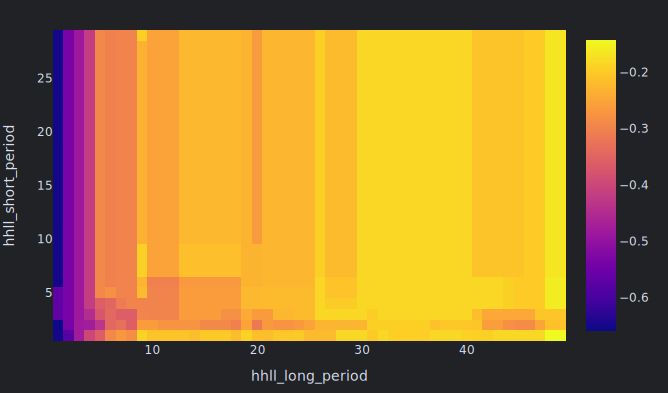

In [169]:
pf.max_drawdown.vbt.heatmap().show_svg()

Now let's rerun the portfolio with all the combinations but place a trailing stop loss

Start                           2021-01-01 00:00:00+00:00
End                             2023-05-26 00:00:00+00:00
Period                                  876 days 00:00:00
Start Value                                         100.0
Min Value                                       94.790001
Max Value                                      571.972112
End Value                                      498.844277
Total Return [%]                               398.844277
Benchmark Return [%]                           147.444815
Total Time Exposure [%]                         42.693261
Max Gross Exposure [%]                         109.593397
Max Drawdown [%]                                24.471995
Max Drawdown Duration         208 days 19:32:28.205489092
Total Orders                                   126.998593
Total Fees Paid                                       0.0
Total Trades                                    68.147783
Win Rate [%]                                     49.53134
Best Trade [%]

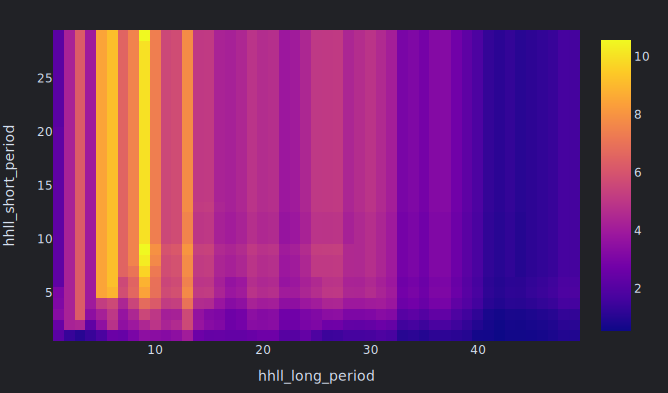

In [168]:
# We need to rebuild the strategy object with all the params
strat = hhll.run(
    eth['High'], 
    eth['Low'], 
    long_period=np.arange(1, 50, 1),
    short_period=np.arange(1, 30, 1),
    param_product=True,
    ) # this creates a vectorbt object of the strategy with all the different parameter combinations

# Add a trailing stop loss to the strategy
pf = vbt.Portfolio.from_signals(
    eth['Close'],
    entries = strat.long_entry, # Note, now we are using the strategy object to get the signals
    exits = strat.long_exit,
    short_entries = strat.short_entry,
    short_exits = strat.short_exit,
    freq = '1D',
    # tp_stop=0.1,
    # tsl_th = 0.10,
    tsl_stop=0.05,
    # sl_stop=0.10,

)
print(pf.stats())

# Isolate the best total return portfolio
best_total_return = pf.total_return.max()
print(f'The best total return of all the combinations is {best_total_return:.2%}')
best_total_return_combination = pf.total_return.idxmax()
print(f'The best combination is {best_total_return_combination}')

# Isolate the best Sharpe ratio portfolio
best_sharpe = pf.sharpe_ratio.max()
print(f'The best Sharpe ratio of all the combinations is {best_sharpe:.2f}')
best_sharpe_combination = pf.sharpe_ratio.idxmax()
print(f'The best combination is {best_sharpe_combination}')

best_max_drawdown = pf.max_drawdown.max()
print(f'The best max drawdown of all the combinations is {best_max_drawdown:.2%}')
best_max_drawdown_combination = pf.max_drawdown.idxmax()
print(f'The best combination is {best_max_drawdown_combination}')


# Plot the heatmap of the total returns
pf.total_return.vbt.heatmap().show_svg()

# Grant's code below

In [51]:
# Calculate long and short trading positions
eth['long_position'] = np.nan
eth.loc[eth['long_entry'], 'long_position'] = 1 # if long entry is true then long position is 1
eth.loc[eth['long_exit'], 'long_position'] = 0
eth['long_position'] = eth['long_position'].fillna(method='ffill')
eth['short_position'] = np.nan
eth.loc[eth['short_entry'], 'short_position'] = -1
eth.loc[eth['short_exit'], 'short_position'] = 0
eth['short_position'] = eth['short_position'].fillna(method='ffill')

In [52]:
# Calculate long and short trading returns
eth['long_returns'] = eth['Close'].pct_change() * eth['long_position']
eth['short_returns'] = eth['Close'].pct_change() * eth['short_position']


<Axes: xlabel='Open time'>

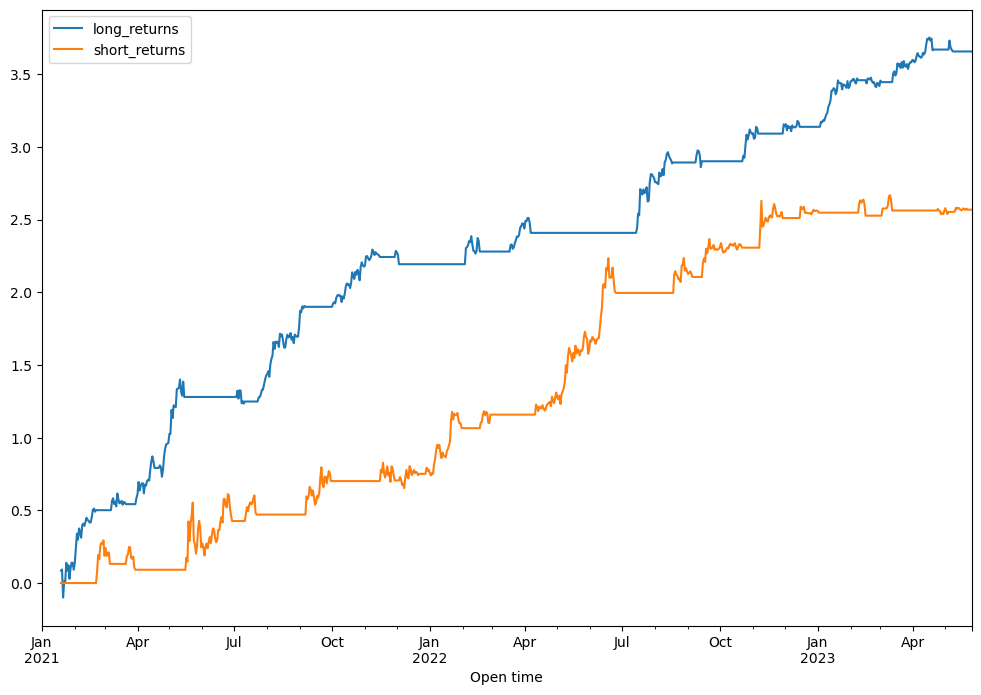

In [53]:
# plot the returns
eth[['long_returns', 'short_returns']].cumsum().plot(figsize=(12,8))


<Axes: xlabel='Open time'>

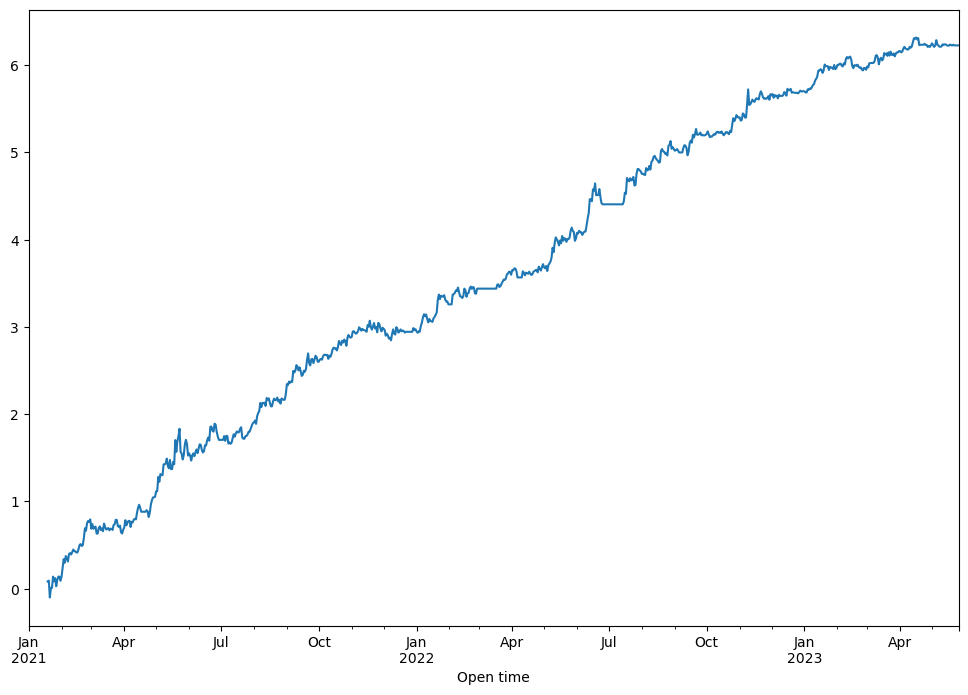

In [54]:
# plot the equity curve 
eth['equity_curve'] = eth['long_returns'].cumsum() + eth['short_returns'].cumsum()
eth['equity_curve'].plot(figsize=(12,8))

In [55]:
# show key statistics 
eth[['long_returns', 'short_returns']].describe()

,long_returns,short_returns
count,858.000000,858.000000
mean,0.004261,0.002993
std,0.028884,0.035068
min,-0.193197,-0.263329
25%,0.000000,0.000000
50%,-0.000000,0.000000
75%,0.001390,0.000000
max,0.181070,0.277372


In [56]:
#show key statistics using vectorbtpro include number of trades and win rate and short performance vs. long performance
eth[['long_returns', 'short_returns']].vbt.returns(freq='1d').stats() 

Start                        2021-01-01 00:00:00+00:00
End                          2023-05-26 00:00:00+00:00
Period                               876 days 00:00:00
Total Return [%]                            1638.10162
Annualized Return [%]                       214.666322
Annualized Volatility [%]                    61.090154
Max Drawdown [%]                             27.181548
Max Drawdown Duration                111 days 12:00:00
Sharpe Ratio                                  2.224318
Calmar Ratio                                  9.553158
Omega Ratio                                   1.639479
Sortino Ratio                                 3.886533
Skew                                          0.735747
Kurtosis                                      10.48876
Tail Ratio                                    1.577947
Common Sense Ratio                            5.018388
Value at Risk                                -0.038868
Name: agg_stats, dtype: object